### Notebook to prepare the full dataset used for training of different models, combining different code throughout this repo


In [203]:
# Importing Libraries

import pandas as pd
import healpy as hp
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [204]:
# Defining important metrics and functions

# Setting NSIDE values
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2pixarea(NSIDE, degrees=True)))


def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


Approximate resolution at NSIDE 256 is 0.23 deg
Approximate resolution at NSIDE 256 is 0.052 deg


### 1. Get a catalogue of all objects in the Galaxy Survey



In [205]:
df_north = pd.read_csv('../../bricks_data/galaxy_catalogue_north.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_north.head()


BrickID          RA        DEC  LRG  ELG  QSO
0   541202  140.895285  39.405974    0    0    1
1   541202  140.895584  39.576038    0    0    1
2   541202  140.895693  39.403449    0    0    1
3   541202  140.896081  39.479529    0    0    1
4   541202  140.896304  39.621573    0    1    0

In [206]:
df_south = pd.read_csv('../../bricks_data/galaxy_catalogue_south.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_south.head()

BrickID          RA       DEC  LRG  ELG  QSO
0   387694  350.870568  9.868695    1    0    0
1   387694  350.871680  9.637755    0    1    0
2   387694  350.872142  9.694869    0    0    1
3   387694  350.872631  9.724626    0    0    1
4   387694  350.873243  9.683394    0    1    0

In [207]:
# exploring the overlap:

intersection = pd.Series(list(set(df_north.BrickID) & set(df_south.BrickID)))
print(len(intersection))

10896


In [208]:
print(len(df_north.BrickID.unique()))
print(len(df_south.BrickID.unique()))
print(len(df_north.BrickID.unique()) + len(df_south.BrickID.unique()))

89085
248966
338051


In [209]:
df = pd.concat((df_south, df_north), axis=0)


In [210]:
df_intersect = df[~(df['BrickID'].isin(intersection))]

In [211]:
print(len(df))
print(len(df_intersect))

119022287
113223027


In [212]:
print(df.shape)
duplicates_removed = df.drop_duplicates()

print(duplicates_removed.shape)

(119022287, 6)
(113219272, 6)


In [213]:
df = duplicates_removed

print(len(df.BrickID.unique()))

316259


In [214]:
print(df.isna().sum())

BrickID         0
RA         143609
DEC        143609
LRG             0
ELG             0
QSO             0
dtype: int64


In [215]:
# Removing all Lines with Nan that were added to ensure that all bricks are stored
df_objects = df.dropna(axis=0, inplace=False, how='any')

print(len(df_objects.BrickID.unique()))
print(len(df_objects))

310072
113075663


In [216]:
df_objects.head()

BrickID          RA       DEC  LRG  ELG  QSO
0   387694  350.870568  9.868695    1    0    0
1   387694  350.871680  9.637755    0    1    0
2   387694  350.872142  9.694869    0    0    1
3   387694  350.872631  9.724626    0    0    1
4   387694  350.873243  9.683394    0    1    0

### 2. Get Galaxy Count per Healpy Pixel


In [217]:
# LRG

df_LRG = df_objects[df_objects["LRG"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, counts), axis=1)
#print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

Number of LRGs in Sample: 12571199
[  1558   1560   1561 ... 757955 758427 758428]
Mean LRGs per Pixel: 33.668195026581145


pixel_id  lrg
0      1558    2
1      1560    1
2      1561    3
3      1562    1
4      1564    2

In [218]:
# elg

df_ELG = df_objects[df_objects["ELG"] == 1]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
#density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

Number of ELGs in Sample: 46936467
[  1558   1559   1560 ... 758428 758429 758430]
Mean ELGs per Pixel: 125.39899331279706
[[  1558      6]
 [  1559      3]
 [  1560      7]
 ...
 [758428     12]
 [758429      4]
 [758430      6]]
   pixel_id  elg
0      1558    6
1      1559    3
2      1560    7
3      1561    4
4      1562    5


In [219]:
df_QSO = df_objects[df_objects["QSO"] == 1]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
#density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

Number of QSOs in Sample: 58986911
[  1558   1559   1560 ... 758428 758429 758430]
Mean QSOs per Pixel: 157.55850590708397
[[  1558      9]
 [  1559      5]
 [  1560      8]
 ...
 [758428      6]
 [758429      6]
 [758430      4]]
   pixel_id  qso
0      1558    9
1      1559    5
2      1560    8
3      1561    6
4      1562    6


In [220]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

pixel_id       0
lrg         1183
elg          271
qso          187
dtype: int64
(373385, 2) (374297, 2) (374381, 2) (374568, 4)


In [221]:
# Dropping all pixels where I do not have counts for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())
print(df.shape)

pixel_id    0
lrg         0
elg         0
qso         0
dtype: int64
(373275, 4)


### 3. Plotting Galaxy Densities

0.0 180.0 -180.0 180.0


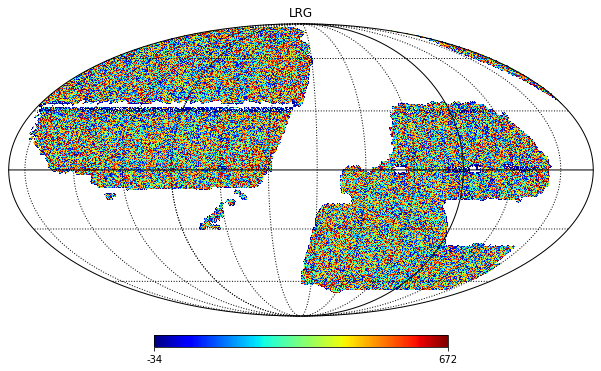

In [222]:
m_LRG = np.zeros(NPIX)

m_LRG[df.pixel_id.to_numpy()] = df.lrg.to_numpy()
mask = (m_LRG == 0)
m_LRG[mask] = np.nan
hp.mollview(m_LRG, title="LRG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


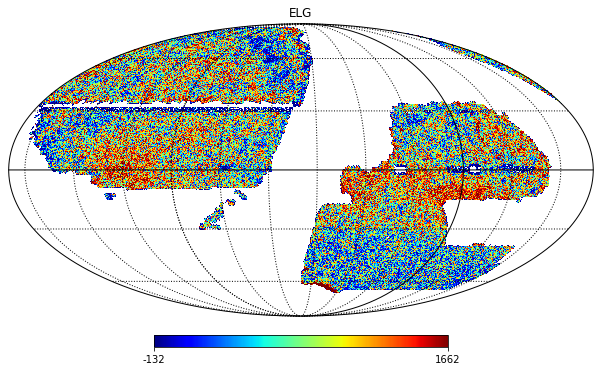

In [223]:
m_ELG = np.zeros(NPIX)

m_ELG[df.pixel_id.to_numpy()] = df.elg.to_numpy()
mask = (m_ELG == 0)
m_ELG[mask] = np.nan
hp.mollview(m_ELG, title="ELG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


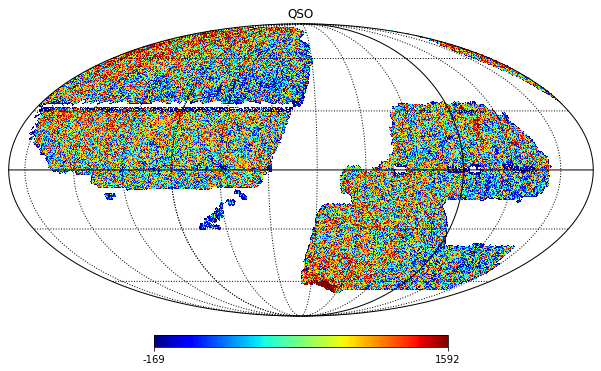

In [224]:
m_QSO = np.zeros(NPIX)

m_QSO[df.pixel_id.to_numpy()] = df.qso.to_numpy()
mask = (m_QSO == 0)
m_QSO[mask] = np.nan
hp.mollview(m_QSO, title="QSO", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [225]:
# Getting Exposure Densities across pixels

with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

In [226]:
df = df.astype(int)
df.head()



pixel_id  lrg  elg  qso
0      1558    2    6    9
1      1560    1    7    8
2      1561    3    4    6
3      1562    1    5    6
4      1564    2    4   10

In [227]:
pix_ids = df.pixel_id.to_numpy()
exp_len = np.zeros(len(pix_ids))
print(pix_ids)
for i, pix in enumerate(pix_ids):
    exp_len[i] = len(pixel2ccd_dict[pix])

print(exp_len)

df['exposures'] = exp_len

df.head()

[  1558   1560   1561 ... 757955 758427 758428]
[10. 11. 10. ...  8.  6.  9.]


pixel_id  lrg  elg  qso  exposures
0      1558    2    6    9       10.0
1      1560    1    7    8       11.0
2      1561    3    4    6       10.0
3      1562    1    5    6       10.0
4      1564    2    4   10       10.0

In [228]:
df = df.astype(int)


0.0 180.0 -180.0 180.0


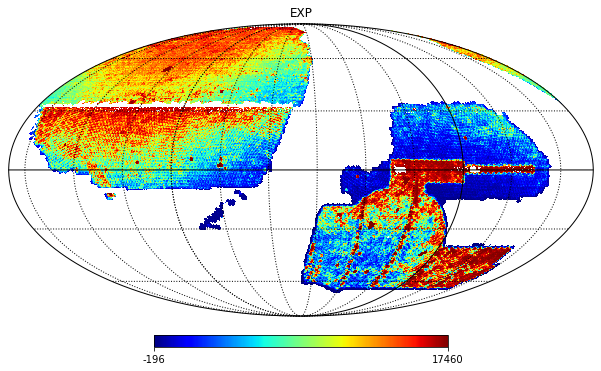

In [229]:
m_EXP = np.zeros(NPIX)

m_EXP[df.pixel_id.to_numpy()] = df.exposures.to_numpy()
mask = (m_EXP == 0)
m_EXP[mask] = np.nan
hp.mollview(m_EXP, title="EXP", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

### 4. Importing the Systematics Values and Appending them to the df.


#### a. Stellar Density

In [230]:
df_stellar_north = pd.read_csv('../../bricks_data/stellar_catalogue_north.csv')


In [231]:
df_stellar_south = pd.read_csv('../../bricks_data/stellar_catalogue_south.csv')

In [232]:
df_stellar_north.head()

RA        DEC       GMAG       RMAG       ZMAG
0  140.898014  39.467598  18.104998  17.247044  16.888790
1  140.931050  39.523490  18.810522  17.796021  17.333416
2  140.957915  39.428128  19.376871  17.902054  16.362108
3  140.972733  39.467930  19.390877  17.886087  16.718546
4  140.981984  39.563177  18.225065  17.742722  17.618404

In [233]:
print(len(df_stellar_north) + len(df_stellar_south))

13434713


In [234]:
df_stellar = pd.concat((df_stellar_south, df_stellar_north), axis=0)


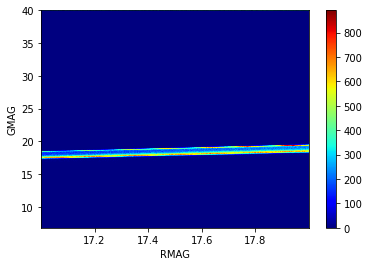

In [235]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [236]:
# REMOVING OUTLIERS
print(df_stellar.shape)

(13434713, 5)


In [237]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [238]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4)]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4)]
print(df_stellar.shape)


(12813535, 7)


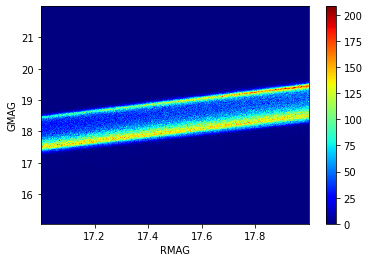

In [239]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()


In [240]:
#Dividing RMAG Column into 1000 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=10000, labels=False)
df_stellar['percent_RMAG'].value_counts()


1699    1326
8449    1324
2170    1324
9798    1323
5097    1323
        ... 
4343    1239
2491    1238
7500    1237
9142    1234
9316    1228
Name: percent_RMAG, Length: 10000, dtype: int64

In [241]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [242]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=10000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=10000, labels=False)
df_stellar.shape

(12813535, 12)

In [243]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [244]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [245]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

(12813535, 12)
(12712118, 12)


(12651217, 12)

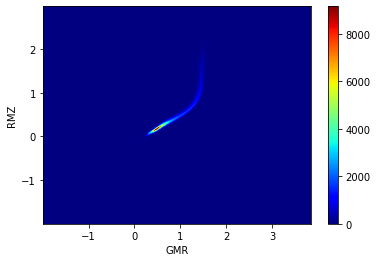

In [246]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [247]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

Number of stellars in Sample: 12651217
[  1560   1561   1562 ... 757955 758426 758427]
Mean stellars per Pixel: 33.15829795041149
[[  1560      1]
 [  1561      3]
 [  1562      2]
 ...
 [757955      4]
 [758426      2]
 [758427      2]]
   pixel_id  stellar
0      1560        1
1      1561        3
2      1562        2
3      1565        3
4      1572        1
pixel_id    0
stellar     0
dtype: int64


In [248]:
df = df.merge(df_stellar, how='inner', on='pixel_id')
print(df.isna().sum())
df.shape

pixel_id     0
lrg          0
elg          0
qso          0
exposures    0
stellar      0
dtype: int64


(373133, 6)

In [249]:
df.head()

pixel_id  lrg  elg  qso  exposures  stellar
0      1560    1    7    8         11        1
1      1561    3    4    6         10        3
2      1562    1    5    6         10        2
3      1565    2   11    7          9        3
4      1572    1    3   10          6        1

0.0 180.0 -180.0 180.0


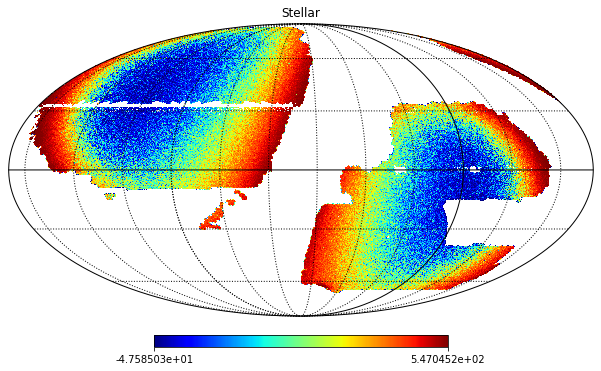

In [250]:
m_Stellar = np.zeros(NPIX)

m_Stellar[df.pixel_id.to_numpy()] = df.stellar.to_numpy()
mask = (m_Stellar == 0)
m_Stellar[mask] = np.nan
hp.mollview(m_Stellar, title="Stellar", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0),
            badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

#### EBV Extraction

In [251]:
from astropy.coordinates import SkyCoord, Latitude, Longitude
from dustmaps.sfd import SFDQuery

In [252]:
from dustmaps.config import config

config['data_dir'] = '/Users/edgareggert/astrostatistics/data_preprocessing/.dustmapsrc'

In [253]:
## Getting the centers of each pixel in my corpus as RaDec

pixels_ids = df["pixel_id"].to_numpy()
print(pixels_ids)
subpixel_coords = hp.pix2ang(NSIDE, pixels_ids, lonlat=True)
ra_ebv = subpixel_coords[0]
dec_ebv = subpixel_coords[1]

[  1560   1561   1562 ... 757954 757955 758427]


In [254]:
#Querying their position on the SFD dustmap
sfd = SFDQuery()
coords = SkyCoord(ra_ebv, dec_ebv, frame='icrs', unit='deg')
ebv = sfd(coords)

df["EBV"] = ebv

In [255]:
df.EBV.describe()
df.head()


pixel_id  lrg  elg  qso  exposures  stellar       EBV
0      1560    1    7    8         11        1  0.157148
1      1561    3    4    6         10        3  0.277929
2      1562    1    5    6         10        2  0.255054
3      1565    2   11    7          9        3  0.247232
4      1572    1    3   10          6        1  0.209759

0.0 180.0 -180.0 180.0


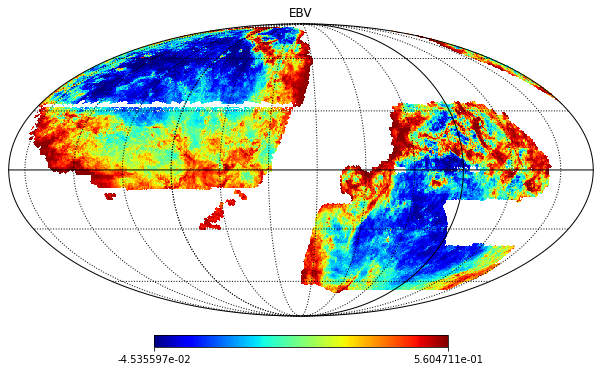

In [256]:
m_EBV = np.zeros(NPIX)

m_EBV[df.pixel_id.to_numpy()] = df.EBV.to_numpy()
mask = (m_EBV == 0)
m_EBV[mask] = np.nan
hp.mollview(m_EBV, title="EBV", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [257]:
df.exposures = df.exposures.astype(int)
df.head()

pixel_id  lrg  elg  qso  exposures  stellar       EBV
0      1560    1    7    8         11        1  0.157148
1      1561    3    4    6         10        3  0.277929
2      1562    1    5    6         10        2  0.255054
3      1565    2   11    7          9        3  0.247232
4      1572    1    3   10          6        1  0.209759

In [258]:
df.to_csv('../../bricks_data/dataset_galdense.csv', index=False)



In [259]:
df = pd.read_csv('../../bricks_data/dataset_galdense.csv',
                 dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                        'EBV': 'float'})

#### Geometric Systematics Values, not involving edge pixels

In [260]:
with open('../../bricks_data/pixel2systematics_geometric_non_inclusive.pickle', 'rb') as f:
    geo_dict = pickle.load(f)
    f.close()

print(len(geo_dict.keys()))

446042


In [261]:
sys_list = []
for key in geo_dict.keys():
    ind_sys_list = geo_dict[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_geo_no = pd.DataFrame(sys_list, columns=['airmass',
                                                'ccdskysb_g',
                                                'ccdskysb_r',
                                                'ccdskysb_z',
                                                'exptime_g',
                                                'exptime_r',
                                                'exptime_z',
                                                'meansky_g',
                                                'meansky_r',
                                                'meansky_z',
                                                'galdepth_g',
                                                'galdepth_r',
                                                'galdepth_z',
                                                'seeing_g',
                                                'seeing_r',
                                                'seeing_z',
                                                'mjd_obs_g',
                                                'mjd_obs_r',
                                                'mjd_obs_z', 'pixel_id'])



In [262]:
print(len((df_sys_geo_no)))

446042


In [263]:
df_geo = df.merge(df_sys_geo_no, how='inner', on='pixel_id')
print(len(df))
print(len(df_geo))

373133
371513


In [264]:
print(df_geo.isna().sum())

pixel_id       0
lrg            0
elg            0
qso            0
exposures      0
stellar        0
EBV            0
airmass        0
ccdskysb_g    52
ccdskysb_r    31
ccdskysb_z     4
exptime_g      0
exptime_r      0
exptime_z      0
meansky_g      0
meansky_r      0
meansky_z      0
galdepth_g     0
galdepth_r     0
galdepth_z     0
seeing_g       0
seeing_r       0
seeing_z       0
mjd_obs_g      0
mjd_obs_r      0
mjd_obs_z      0
dtype: int64


In [265]:
df_geo.dropna(axis=0, inplace=True)
print(df_geo.isna().sum())

pixel_id      0
lrg           0
elg           0
qso           0
exposures     0
stellar       0
EBV           0
airmass       0
ccdskysb_g    0
ccdskysb_r    0
ccdskysb_z    0
exptime_g     0
exptime_r     0
exptime_z     0
meansky_g     0
meansky_r     0
meansky_z     0
galdepth_g    0
galdepth_r    0
galdepth_z    0
seeing_g      0
seeing_r      0
seeing_z      0
mjd_obs_g     0
mjd_obs_r     0
mjd_obs_z     0
dtype: int64


In [266]:
print(df_geo.describe())

            pixel_id            lrg            elg            qso  \
count  371433.000000  371433.000000  371433.000000  371433.000000   
mean   340164.732089      33.778175     126.040182     158.469404   
std    205703.761584      13.617375      29.253816      36.595893   
min      1667.000000       1.000000       1.000000       1.000000   
25%    176675.000000      26.000000     112.000000     141.000000   
50%    323036.000000      32.000000     126.000000     158.000000   
75%    469375.000000      40.000000     141.000000     176.000000   
max    757954.000000     708.000000    2936.000000    2040.000000   

           exposures        stellar            EBV        airmass  \
count  371433.000000  371433.000000  371433.000000  371433.000000   
mean       99.365406      32.873178       0.042393       1.350282   
std       245.834093      28.775140       0.033002       0.253528   
min         5.000000       1.000000       0.000583       1.000179   
25%        46.000000      15.0000

In [267]:
df_geo.to_csv('../../bricks_data/dataset_geometric.csv', index=False)


#### Plotting All Densities and systematics together


In [268]:
df_geo = pd.read_csv('../../bricks_data/dataset_geometric.csv',
                     dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                            'EBV': 'float'})
cols = list(df_geo.columns)
cols.remove('pixel_id')


In [269]:
df_geo.head()

pixel_id  lrg  elg  qso  exposures  stellar       EBV   airmass  \
0      1667   10   31   48         14        5  0.060365  1.686962   
1      1668    7   30   43         14        7  0.071565  1.692857   
2      1669    9   38   44         15        6  0.065674  1.691899   
3      1670    8   45   53         12       10  0.076584  1.699775   
4      1671    9   40   54         13       16  0.114809  1.721909   

   ccdskysb_g  ccdskysb_r  ...  meansky_z  galdepth_g  galdepth_r  galdepth_z  \
0   23.600771   21.159200  ...   2.742672   23.694138   22.136670   22.128330   
1   23.556622   21.281648  ...   2.778888   23.640343   22.062388   22.071468   
2   23.558167   21.281731  ...   3.105660   23.717670   22.057124   22.279951   
3   23.498325   21.441406  ...   3.138674   23.799055   22.207214   22.234135   
4   23.496811   21.440643  ...   3.159713   23.899290   22.195226   22.321754   

   seeing_g  seeing_r  seeing_z     mjd_obs_g     mjd_obs_r     mjd_obs_z  
0   1.01132  0.990884   1.07420  58492.418147  58383.973087  58133.237367  
1   0.98774  0.992980   1.05848  58492.423845  58414.840271  58133.237367  
2   0.99298  1.033153   1.08730  58492.423845  58414.840271  58121.200984  
3   0.86198  0.977260   1.12398  58499.525547  58414.860381  58121.200984  
4   0.87770  1.022673   1.01918  58499.525547  58414.860381  58054.406343  

[5 rows x 26 columns]

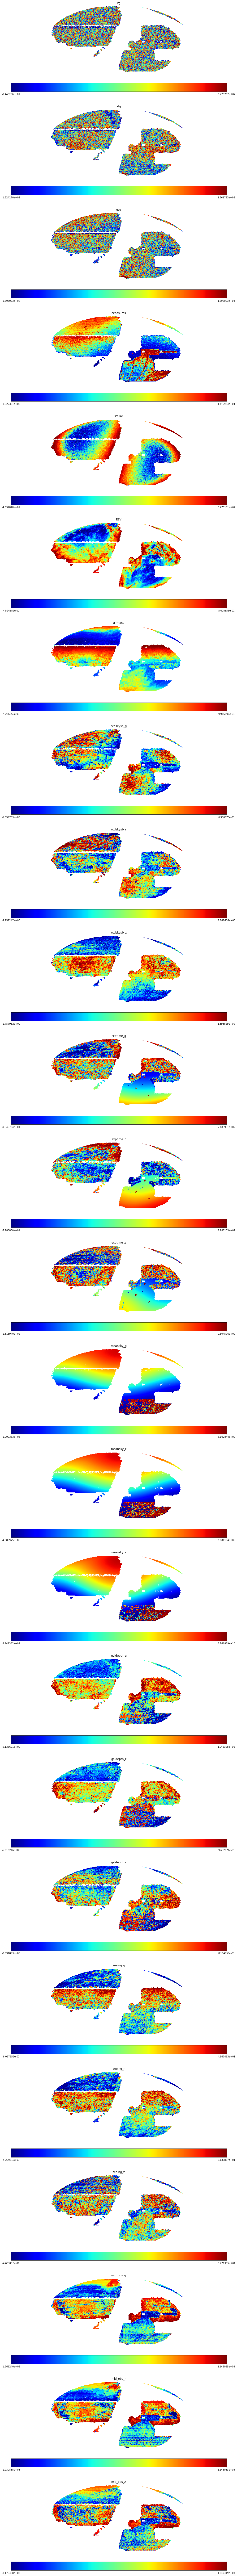

In [270]:
nrows = 25
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(200,200))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]

    m = np.zeros(NPIX)

    m[df_geo.pixel_id.to_numpy()] = df_geo[elem].to_numpy()
    mask = (m == 0)
    m[mask] = np.nan
    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1),format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True, hold=True)
    #hp.graticule()
    i += 1

plt.show()


### 5. Outlier Removal

In [271]:
df_geo = pd.read_csv('../../bricks_data/dataset_geometric.csv',
                     dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                            'EBV': 'float'})

df_geo.describe()

pixel_id            lrg            elg            qso  \
count  371433.000000  371433.000000  371433.000000  371433.000000   
mean   340164.732089      33.778175     126.040182     158.469404   
std    205703.761584      13.617375      29.253816      36.595893   
min      1667.000000       1.000000       1.000000       1.000000   
25%    176675.000000      26.000000     112.000000     141.000000   
50%    323036.000000      32.000000     126.000000     158.000000   
75%    469375.000000      40.000000     141.000000     176.000000   
max    757954.000000     708.000000    2936.000000    2040.000000   

           exposures        stellar            EBV        airmass  \
count  371433.000000  371433.000000  371433.000000  371433.000000   
mean       99.365406      32.873178       0.042393       1.350282   
std       245.834093      28.775140       0.033002       0.253528   
min         5.000000       1.000000       0.000583       1.000179   
25%        46.000000      15.000000       0.019812       1.180196   
50%        68.000000      23.000000       0.033056       1.268957   
75%       139.000000      39.000000       0.054012       1.474964   
max     17612.000000    1919.000000       0.854514       2.385126   

          ccdskysb_g     ccdskysb_r  ...     meansky_z     galdepth_g  \
count  371433.000000  371433.000000  ...  3.714330e+05  371433.000000   
mean       23.467463      22.589152  ...  8.315186e+08      23.671935   
std         0.179777       0.226529  ...  3.316159e+09       0.303878   
min        18.267529      18.225866  ...  0.000000e+00      18.361883   
25%        23.387204      22.478830  ...  2.047380e+00      23.501989   
50%        23.490153      22.613641  ...  2.509586e+00      23.736220   
75%        23.576204      22.728811  ...  3.336942e+00      23.877205   
max        24.377570      25.279337  ...  9.433031e+10      24.705928   

          galdepth_r     galdepth_z       seeing_g       seeing_r  \
count  371433.000000  371433.000000  371433.000000  371433.000000   
mean       23.159599      22.227524       1.227238       1.106018   
std         0.337525       0.267117       0.468245       0.316725   
min        15.734725       0.000000       0.573780       0.542340   
25%        22.939479      22.166204       1.090902       0.987148   
50%        23.232927      22.288780       1.242252       1.124312   
75%        23.360485      22.379924       1.356500       1.219934   
max        24.181324      27.191251      53.560776      32.342494   

            seeing_z      mjd_obs_g      mjd_obs_r      mjd_obs_z  
count  371433.000000  371433.000000  371433.000000  371433.000000  
mean        1.100836   57794.731447   57785.430585   57680.891410  
std         0.359605     358.491014     354.320339     307.400354  
min         0.000000   56536.000831   56536.081054       0.000000  
25%         0.991382   57524.873252   57508.319290   57474.258555  
50%         1.077179   57795.683911   57773.484307   57648.672791  
75%         1.179873   58070.303597   58064.923593   57875.469036  
max        58.909491   58662.327740   58661.994609   58679.138231  

[8 rows x 26 columns]

In [272]:
zscore = lambda x: abs((x - x.median()) / x.std())
col = list(df_geo.columns)
df_no_outlier = df_geo


#### Removing All Outliers


In [273]:
df_no_outlier = df_geo
factor = 10
print(len(df_geo))
for elem in col:
    if elem == 'stellar':
        factor = 10
    df_no_outlier['Z'] = df_no_outlier[elem].transform(zscore)
    print("Element: ", elem, "| No of Elems with Z higher than factor  : ", len(df_no_outlier[(df_no_outlier['Z'] > factor)]))
    df_no_outlier = df_no_outlier[(df_no_outlier['Z'] < factor)]

print()
print(f"Galaxies Remaining before outlier removal: {len(df_geo)}")
print(f"Galaxies Remaining after outlier removal: {len(df_no_outlier)}")
print(f"Elements cut by outlier removal: {len(df_geo) - len(df_no_outlier)}")

371433
Element:  pixel_id | No of Elems with Z higher than factor  :  0
Element:  lrg | No of Elems with Z higher than factor  :  246
Element:  elg | No of Elems with Z higher than factor  :  169
Element:  qso | No of Elems with Z higher than factor  :  89
Element:  exposures | No of Elems with Z higher than factor  :  488
Element:  stellar | No of Elems with Z higher than factor  :  12
Element:  EBV | No of Elems with Z higher than factor  :  63
Element:  airmass | No of Elems with Z higher than factor  :  0
Element:  ccdskysb_g | No of Elems with Z higher than factor  :  348
Element:  ccdskysb_r | No of Elems with Z higher than factor  :  110
Element:  ccdskysb_z | No of Elems with Z higher than factor  :  1
Element:  exptime_g | No of Elems with Z higher than factor  :  0
Element:  exptime_r | No of Elems with Z higher than factor  :  0
Element:  exptime_z | No of Elems with Z higher than factor  :  0
Element:  meansky_g | No of Elems with Z higher than factor  :  154
Element:  mean

In [274]:
#df_no_outlier = df_geo

df_no_outlier.describe()
print(df_no_outlier.shape)
print(df_no_outlier.exposures.max())

df_no_outlier = df_no_outlier[df_no_outlier.exposures < 300]
print(df_no_outlier.shape)

df_no_outlier.exposures.max()


(368858, 27)
2522
(367167, 27)


299

### Scaling the Data

In [275]:
scaler = MinMaxScaler()
#scaler = RobustScaler()

df_scaled = df_no_outlier

cololo = list(df_scaled.columns)
cololo.remove('pixel_id')

df_scaled[cololo] = scaler.fit_transform(df_no_outlier[cololo])

df_scaled.describe()

pixel_id            lrg            elg            qso  \
count  367167.000000  367167.000000  367167.000000  367167.000000   
mean   338058.465946       0.195599       0.302875       0.325838   
std    204549.521061       0.074195       0.061229       0.065962   
min      1667.000000       0.000000       0.000000       0.000000   
25%    174347.500000       0.149701       0.269417       0.290456   
50%    321014.000000       0.185629       0.303398       0.325726   
75%    464372.500000       0.233533       0.339806       0.363071   
max    757954.000000       1.000000       1.000000       1.000000   

           exposures        stellar            EBV        airmass  \
count  367167.000000  367167.000000  367167.000000  367167.000000   
mean        0.290328       0.126175       0.115728       0.253765   
std         0.208027       0.112671       0.090253       0.183418   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.139456       0.055556       0.053356       0.130712   
50%         0.214286       0.087302       0.090068       0.194752   
75%         0.428571       0.150794       0.148074       0.344331   
max         1.000000       1.000000       1.000000       1.000000   

          ccdskysb_g     ccdskysb_r  ...     galdepth_g     galdepth_r  \
count  367167.000000  367167.000000  ...  367167.000000  367167.000000   
mean        0.659684       0.643845  ...       0.735552       0.759789   
std         0.059210       0.063487  ...       0.073606       0.076814   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.628410       0.610914  ...       0.691216       0.707588   
50%         0.666882       0.650453  ...       0.751116       0.776424   
75%         0.699153       0.684238  ...       0.786928       0.806353   
max         1.000000       1.000000  ...       1.000000       1.000000   

          galdepth_z       seeing_g       seeing_r       seeing_z  \
count  367167.000000  367167.000000  367167.000000  367167.000000   
mean        0.728269       0.177280       0.169458       0.121913   
std         0.073466       0.056676       0.057222       0.038309   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.710309       0.141853       0.134270       0.095453   
50%         0.744991       0.183688       0.176136       0.117191   
75%         0.770978       0.215111       0.205138       0.143133   
max         1.000000       1.000000       1.000000       1.000000   

           mjd_obs_g      mjd_obs_r      mjd_obs_z              Z  
count  367167.000000  367167.000000  367167.000000  367167.000000  
mean        0.593301       0.590425       0.532375       0.210936  
std         0.168000       0.166477       0.137119       0.163979  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.467643       0.460432       0.435218       0.081886  
50%         0.593855       0.585892       0.517220       0.172425  
75%         0.723010       0.721680       0.623581       0.306893  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 27 columns]

### Separating train, test and validation sets

In [276]:
df_train, df_val = train_test_split(df_scaled, test_size=0.4, random_state=666, shuffle=True)
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=666, shuffle=True)

total = len(df_train) + len(df_test) + len(df_val)

print(len(df_train)/total)
print(len(df_val)/total)
print(len(df_test)/total)

0.5999994552887378
0.19999891057747565
0.20000163413378652


In [277]:
df_train.describe()

pixel_id            lrg            elg            qso  \
count  220300.000000  220300.000000  220300.000000  220300.000000   
mean   338079.707009       0.195636       0.302838       0.325800   
std    204495.855099       0.074449       0.061192       0.066051   
min      1667.000000       0.000000       0.000000       0.000000   
25%    174364.250000       0.149701       0.269417       0.290456   
50%    321457.500000       0.185629       0.303398       0.325726   
75%    464377.250000       0.233533       0.339806       0.363071   
max    757954.000000       1.000000       0.995146       1.000000   

           exposures        stellar            EBV        airmass  \
count  220300.000000  220300.000000  220300.000000  220300.000000   
mean        0.289873       0.126299       0.115688       0.253775   
std         0.207605       0.112520       0.090189       0.183273   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.139456       0.055556       0.053356       0.130730   
50%         0.214286       0.087302       0.089940       0.195064   
75%         0.425170       0.150794       0.148146       0.344010   
max         1.000000       0.984127       1.000000       1.000000   

          ccdskysb_g     ccdskysb_r  ...     galdepth_g     galdepth_r  \
count  220300.000000  220300.000000  ...  220300.000000  220300.000000   
mean        0.659638       0.643876  ...       0.735582       0.759901   
std         0.059272       0.063410  ...       0.073716       0.076581   
min         0.005615       0.001020  ...       0.000000       0.004909   
25%         0.628380       0.611027  ...       0.691273       0.707656   
50%         0.666802       0.650488  ...       0.751224       0.776547   
75%         0.699135       0.684214  ...       0.787062       0.806323   
max         1.000000       1.000000  ...       1.000000       0.989192   

          galdepth_z       seeing_g       seeing_r       seeing_z  \
count  220300.000000  220300.000000  220300.000000  220300.000000   
mean        0.728303       0.177254       0.169419       0.121953   
std         0.073403       0.056673       0.057273       0.038387   
min         0.000000       0.000000       0.001588       0.000000   
25%         0.710344       0.141853       0.134008       0.095510   
50%         0.744976       0.183585       0.176023       0.117265   
75%         0.770993       0.215003       0.205138       0.143241   
max         1.000000       1.000000       0.990049       0.995463   

           mjd_obs_g      mjd_obs_r      mjd_obs_z              Z  
count  220300.000000  220300.000000  220300.000000  220300.000000  
mean        0.593306       0.590407       0.532442       0.211118  
std         0.168084       0.166472       0.137181       0.163963  
min         0.000939       0.000971       0.000000       0.000000  
25%         0.468169       0.460776       0.435003       0.081768  
50%         0.594010       0.586144       0.517443       0.173013  
75%         0.722741       0.721648       0.623837       0.306971  
max         1.000000       0.999993       1.000000       1.000000  

[8 rows x 27 columns]

In [278]:
df_val.describe()

pixel_id           lrg           elg           qso     exposures  \
count   73433.000000  73433.000000  73433.000000  73433.000000  73433.000000   
mean   337705.461400      0.195521      0.302828      0.325577      0.290768   
std    204564.343993      0.073995      0.061450      0.066140      0.208911   
min      1672.000000      0.000000      0.000000      0.000000      0.000000   
25%    174111.000000      0.149701      0.269417      0.290456      0.139456   
50%    319614.000000      0.185629      0.303398      0.325726      0.214286   
75%    463488.000000      0.227545      0.339806      0.363071      0.428571   
max    757472.000000      1.000000      1.000000      0.964730      1.000000   

            stellar           EBV       airmass    ccdskysb_g    ccdskysb_r  \
count  73433.000000  73433.000000  73433.000000  73433.000000  73433.000000   
mean       0.126194      0.116022      0.253974      0.659714      0.643846   
std        0.113613      0.090439      0.183713      0.059082      0.063404   
min        0.000000      0.002042      0.002829      0.000000      0.000000   
25%        0.055556      0.053313      0.130604      0.628452      0.610838   
50%        0.087302      0.090402      0.194307      0.666976      0.650468   
75%        0.150794      0.148133      0.345416      0.699255      0.684310   
max        1.000000      0.987182      0.977345      0.870445      0.923450   

       ...    galdepth_g    galdepth_r    galdepth_z      seeing_g  \
count  ...  73433.000000  73433.000000  73433.000000  73433.000000   
mean   ...      0.735587      0.759564      0.728119      0.177289   
std    ...      0.073456      0.076975      0.073729      0.056424   
min    ...      0.031462      0.017651      0.033561      0.004328   
25%    ...      0.690983      0.707244      0.709950      0.141620   
50%    ...      0.750899      0.776376      0.744811      0.183769   
75%    ...      0.786817      0.806287      0.770988      0.215325   
max    ...      0.987665      1.000000      0.949552      0.853524   

           seeing_r      seeing_z     mjd_obs_g     mjd_obs_r     mjd_obs_z  \
count  73433.000000  73433.000000  73433.000000  73433.000000  73433.000000   
mean       0.169510      0.121879      0.593415      0.590582      0.532495   
std        0.057019      0.038277      0.168195      0.166610      0.137415   
min        0.000000      0.000033      0.000000      0.000000      0.000000   
25%        0.134440      0.095251      0.467396      0.460338      0.435719   
50%        0.176370      0.117117      0.593830      0.585892      0.517016   
75%        0.205277      0.143133      0.723303      0.721693      0.623528   
max        0.571041      1.000000      0.999474      1.000000      1.000000   

                  Z  
count  73433.000000  
mean       0.211243  
std        0.164555  
min        0.000003  
25%        0.082276  
50%        0.171606  
75%        0.307178  
max        1.000000  

[8 rows x 27 columns]

In [279]:
df_test.describe()

pixel_id           lrg           elg           qso     exposures  \
count   73434.000000  73434.000000  73434.000000  73434.000000  73434.000000   
mean   338347.743075      0.195566      0.303030      0.326211      0.291254   
std    204697.893811      0.073628      0.061119      0.065517      0.208402   
min      1669.000000      0.000000      0.000000      0.000000      0.000000   
25%    174629.750000      0.149701      0.269417      0.292531      0.139456   
50%    321442.000000      0.185629      0.303398      0.327801      0.214286   
75%    464578.000000      0.233533      0.339806      0.363071      0.442177   
max    757953.000000      0.988024      0.966019      0.968880      1.000000   

            stellar           EBV       airmass    ccdskysb_g    ccdskysb_r  \
count  73434.000000  73434.000000  73434.000000  73434.000000  73434.000000   
mean       0.125786      0.115552      0.253525      0.659790      0.643753   
std        0.112180      0.090260      0.183559      0.059152      0.063799   
min        0.000000      0.001935      0.000629      0.002220      0.009009   
25%        0.055556      0.053396      0.130799      0.628453      0.610631   
50%        0.087302      0.090168      0.194249      0.667005      0.650319   
75%        0.150794      0.147860      0.343875      0.699061      0.684200   
max        0.964286      0.999219      0.999930      0.915106      0.923533   

       ...    galdepth_g    galdepth_r    galdepth_z      seeing_g  \
count  ...  73434.000000  73434.000000  73434.000000  73434.000000   
mean   ...      0.735426      0.759676      0.728317      0.177349   
std    ...      0.073425      0.077352      0.073392      0.056938   
min    ...      0.058526      0.000000      0.065357      0.010098   
25%    ...      0.691229      0.707749      0.710564      0.142011   
50%    ...      0.750994      0.776123      0.745226      0.183944   
75%    ...      0.786641      0.806490      0.770914      0.215225   
max    ...      0.997854      1.000000      0.962479      0.907948   

           seeing_r      seeing_z     mjd_obs_g     mjd_obs_r     mjd_obs_z  \
count  73434.000000  73434.000000  73434.000000  73434.000000  73434.000000   
mean       0.169522      0.121829      0.593172      0.590323      0.532053   
std        0.057273      0.038104      0.167555      0.166362      0.136637   
min        0.004764      0.004831      0.000000      0.000000      0.000000   
25%        0.134908      0.095537      0.466460      0.459716      0.435515   
50%        0.176254      0.117071      0.593316      0.585609      0.516803   
75%        0.205037      0.142882      0.723170      0.721713      0.622786   
max        1.000000      0.972443      0.999011      0.999990      1.000000   

                  Z  
count  73434.000000  
mean       0.210084  
std        0.163448  
min        0.000000  
25%        0.081843  
50%        0.170911  
75%        0.306469  
max        1.000000  

[8 rows x 27 columns]

In [280]:
df_train.to_csv('../../bricks_data/train.csv', index=False)
df_val.to_csv('../../bricks_data/val.csv', index=False)
df_test.to_csv('../../bricks_data/test.csv', index=False)


### Plotting all different types of outliers that are removed

#### a. exposures


In [5]:
zscore = lambda x: abs((x - x.median()) / x.std())

df_geo = pd.read_csv('../../bricks_data/dataset_geometric.csv',
                     dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                            'EBV': 'float'})

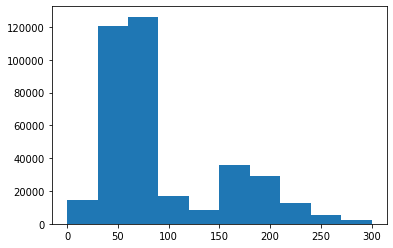

In [6]:

plt.hist(df_geo.exposures, range=[0, 300])
df_no_outlier = df_geo

0.0 180.0 -180.0 180.0


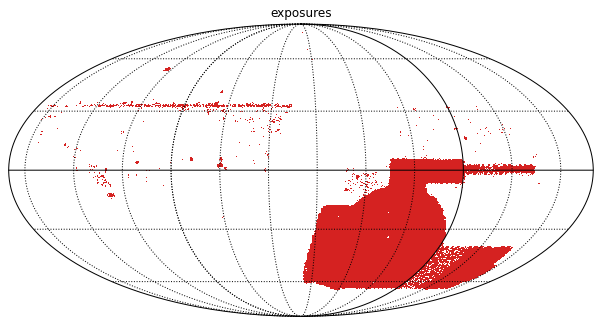

In [33]:
elem = 'exposures'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['exposures'] > 100)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### b. pixel_id -> Plotting State of Current Catalogue



/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/rotator.py:646: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)
0.0 180.0 -180.0 180.0


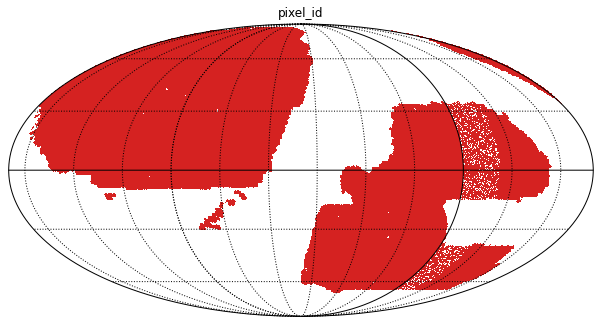

In [8]:
elem = 'pixel_id'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] < 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### c. lrg


0.0 180.0 -180.0 180.0


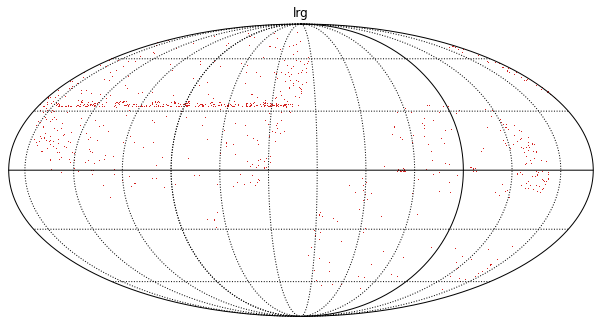

In [9]:
elem = 'lrg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### d. elg


0.0 180.0 -180.0 180.0


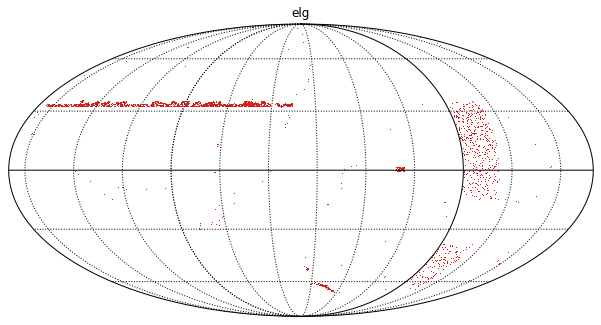

In [10]:
elem = 'elg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. qso


0.0 180.0 -180.0 180.0


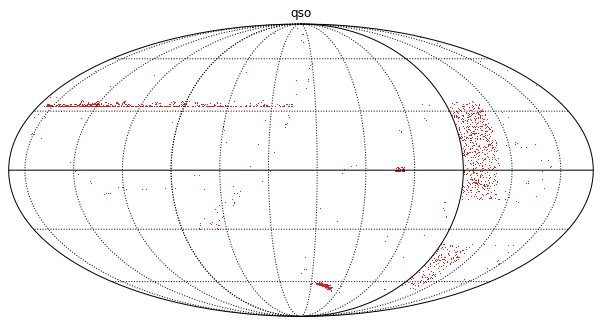

In [11]:
elem = 'qso'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. stellar


0.0 180.0 -180.0 180.0


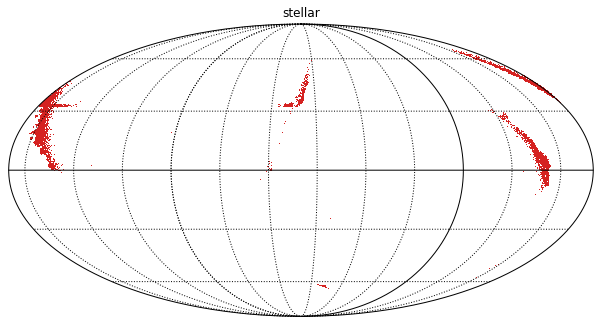

In [12]:
elem = 'stellar'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### f. EBV



0.0 180.0 -180.0 180.0


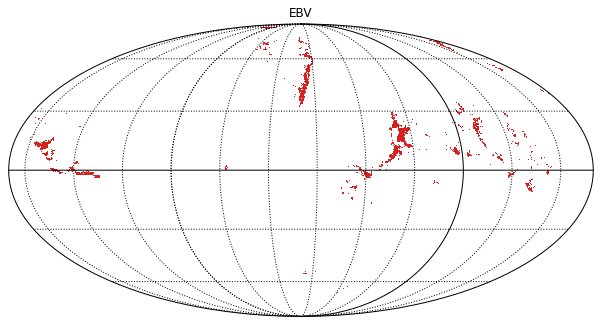

In [13]:
elem = 'EBV'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### g. exptime_g

0.0 180.0 -180.0 180.0


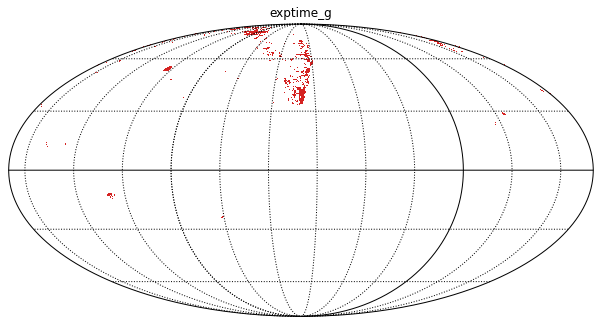

In [14]:
elem = 'exptime_g'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()


#### Plotting All combined

In [15]:
cols = list(df_geo.columns)
cols.remove('pixel_id')
cols.remove('Z')
print(len(cols))

25


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/rotator.py:646: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


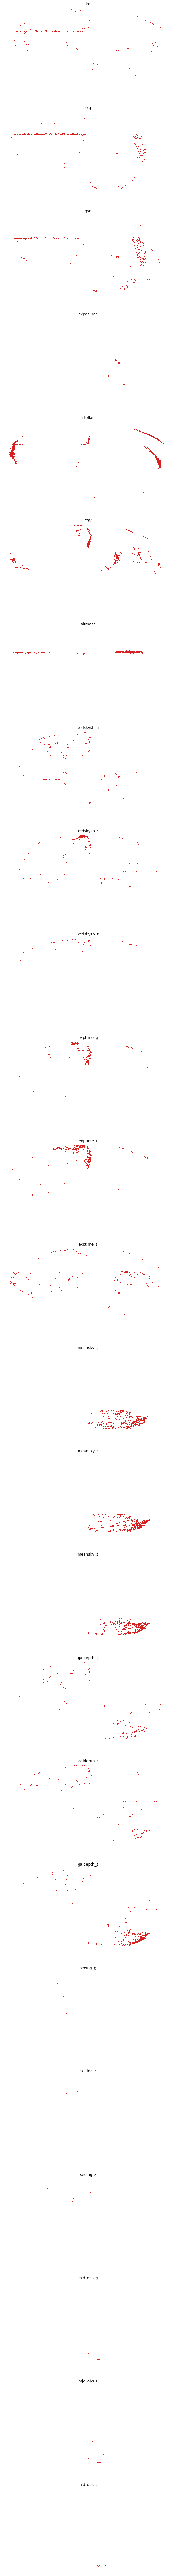

In [16]:
nrows = 25
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(150,150))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]
    df_no_outlier['Z'] = df_geo[elem].transform(zscore)

    df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

    m = np.zeros(NPIX)

    m[df_outlier.pixel_id.to_numpy()] = 1
    mask = (m == 0)
    m[mask] = np.nan

    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1), min=-5, max=2, cbar=False, cmap="Reds", notext=False,
                rot=(100, 0, 0), badcolor='white',
                remove_dip=True, remove_mono=True, hold=True)
    #hp.graticule()
    i += 1

plt.show()
